# Tutorial 3. Use SEDR to do batch integration.

Here we use 3 sections from DLPFC data to show the ability of SEDR to integrate batches for the same tissue with the same techniques. 

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import scanpy as sc

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
from tqdm import tqdm



In [2]:
import SEDR

In [3]:
SEDR.fix_seed(1)

In [4]:
data_root = Path('../../../data/DLPFC/')

proj_list = [
    '151507', '151508', '151509', '151510'
]

## Combining datasets

Input of SEDR includes an AnnData object that contains the spatial transcriptomics data and a graph dictionary that contains the neighborhood graph. When combining two datasets, the AnnData objects are directly concatenated. For neighborhood graphs, we follow the following algorithm.  
Let $A^k$ and $Z_f^k$ denote the adjacency matrix and deep gene representation of spatial omics k, we then create a block-diagonal adjacency matrix $A^k$  and concatenate the deep gene representation in the spot dimension, as:  
![](batch_integration.png)  
where K is the number of spatial omics. 


In [5]:
for proj_name in tqdm(proj_list):
    adata_tmp = sc.read_visium(data_root / proj_name, count_file=proj_name+'_filtered_feature_bc_matrix.h5')
    adata_tmp.var_names_make_unique()

    adata_tmp.obs['batch_name'] = proj_name
    graph_dict_tmp = SEDR.graph_construction(adata_tmp, 12)
    
    ##### Load layer_guess label, if have
    df_label = pd.read_csv(data_root / proj_name / 'manual_annotations.txt', sep='\t', header=None, index_col=0)
    df_label.columns = ['layer_guess']
    adata_tmp.obs['layer_guess'] = df_label['layer_guess']
    
    if proj_name == proj_list[0]:
        adata = adata_tmp
        graph_dict = graph_dict_tmp
        name = proj_name
        adata.obs['proj_name'] = proj_name
    else:
        var_names = adata.var_names.intersection(adata_tmp.var_names)
        adata = adata[:, var_names]
        adata_tmp = adata_tmp[:, var_names]
        adata_tmp.obs['proj_name'] = proj_name
    
        adata = adata.concatenate(adata_tmp)
        graph_dict = SEDR.combine_graph_dict(graph_dict, graph_dict_tmp)
        name = name + '_' + proj_name

100%|██████████| 4/4 [00:13<00:00,  3.27s/it]


## Preprocessing

In [6]:
adata.layers['count'] = adata.X.toarray()
sc.pp.filter_genes(adata, min_cells=50)
sc.pp.filter_genes(adata, min_counts=10)
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", layer='count', n_top_genes=2000)
adata = adata[:, adata.var['highly_variable'] == True]
sc.pp.scale(adata)

from sklearn.decomposition import PCA  # sklearn PCA is used because PCA in scanpy is not stable. 
adata_X = PCA(n_components=200, random_state=42).fit_transform(adata.X)
adata.obsm['X_pca'] = adata_X

## Training SEDR

In [7]:
sedr_net = SEDR.Sedr(adata.obsm['X_pca'], graph_dict, mode='clustering', device='cuda:0')
using_dec = False
if using_dec:
    sedr_net.train_with_dec()
else:
    sedr_net.train_without_dec()
sedr_feat, _, _, _ = sedr_net.process()
adata.obsm['SEDR'] = sedr_feat

100%|██████████| 200/200 [00:19<00:00, 10.46it/s]


## use harmony to calculate revised PCs

In [8]:
import harmonypy as hm

meta_data = adata.obs[['batch_name']]

data_mat = adata.obsm['SEDR']
vars_use = ['batch_name']
ho = hm.run_harmony(data_mat, meta_data, vars_use)

res = pd.DataFrame(ho.Z_corr).T
res_df = pd.DataFrame(data=res.values, columns=['X{}'.format(i+1) for i in range(res.shape[1])], index=adata.obs.index)
adata.obsm[f'SEDR.Harmony'] = res_df.to_numpy()

2025-01-12 15:33:22,135 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-01-12 15:33:24,180 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-01-12 15:33:24,277 - harmonypy - INFO - Iteration 1 of 10
2025-01-12 15:33:28,139 - harmonypy - INFO - Iteration 2 of 10
2025-01-12 15:33:32,093 - harmonypy - INFO - Iteration 3 of 10
2025-01-12 15:33:36,145 - harmonypy - INFO - Iteration 4 of 10
2025-01-12 15:33:40,102 - harmonypy - INFO - Iteration 5 of 10
2025-01-12 15:33:44,004 - harmonypy - INFO - Iteration 6 of 10
2025-01-12 15:33:47,993 - harmonypy - INFO - Iteration 7 of 10
2025-01-12 15:33:50,553 - harmonypy - INFO - Iteration 8 of 10
2025-01-12 15:33:52,464 - harmonypy - INFO - Iteration 9 of 10
2025-01-12 15:33:54,457 - harmonypy - INFO - Iteration 10 of 10
2025-01-12 15:33:56,163 - harmonypy - INFO - Stopped before convergence


In [9]:
SEDR.mclust_R(adata, use_rep='SEDR.Harmony', key_added='mclust', n_clusters=7)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


AnnData object with n_obs × n_vars = 18033 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'batch_name', 'layer_guess', 'proj_name', 'batch', 'mclust'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg'
    obsm: 'spatial', 'X_pca', 'SEDR', 'SEDR.Harmony'
    layers: 'count'

In [10]:
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import normalized_mutual_info_score as nmi_score
from sklearn.metrics import adjusted_mutual_info_score as ami_score
from sklearn.metrics import homogeneity_score as hom_score
from sklearn.metrics import completeness_score as com_score
from my6_Triplet.utils import compute_PAS, compute_CHAOS

indices = np.logical_not(adata.obs["layer_guess"].isna())
ground_truth = adata.obs["layer_guess"].dropna()
ARI = adjusted_rand_score(ground_truth[indices], adata.obs['mclust'][indices])
print(f"total ARI:{ARI}")
for name in proj_list:
    sub_adata_tmp = adata[adata.obs['batch_name'] == name]
    ARI = adjusted_rand_score(sub_adata_tmp.obs['layer_guess'][indices], sub_adata_tmp.obs['mclust'][indices])
    print(f"{name} ARI:{ARI}")

total ARI:0.4264458067691184
151507 ARI:0.45859714074028896
151508 ARI:0.4595353995550924
151509 ARI:0.42648710977826776
151510 ARI:0.4542813486474964


In [11]:
NMI = nmi_score(ground_truth[indices], adata.obs['mclust'][indices])
AMI = ami_score(ground_truth[indices], adata.obs['mclust'][indices])
print(f"total NMI:{NMI}")
print(f"total NMI:{AMI}")
for name in proj_list:
    sub_adata_tmp = adata[adata.obs['batch_name'] == name]
    NMI = nmi_score(sub_adata_tmp.obs['layer_guess'][indices], sub_adata_tmp.obs['mclust'][indices])
    AMI = ami_score(sub_adata_tmp.obs['layer_guess'][indices], sub_adata_tmp.obs['mclust'][indices])
    ACC = 1/2 * (NMI + AMI)
    print(f"ACC:{ACC}")

total NMI:0.6037289962216346
total NMI:0.6035083306151946
ACC:0.647283397467481
ACC:0.6408334686677837
ACC:0.6380369568837772
ACC:0.6417718693817184


In [12]:
HOM = hom_score(ground_truth[indices], adata.obs['mclust'][indices])
COM = com_score(ground_truth[indices], adata.obs['mclust'][indices])
print(f"total HOM:{HOM}")
print(f"total COM:{COM}")
for name in proj_list:
    sub_adata_tmp = adata[adata.obs['batch_name'] == name]
    HOM = hom_score(sub_adata_tmp.obs['layer_guess'][indices], sub_adata_tmp.obs['mclust'][indices])
    COM = com_score(sub_adata_tmp.obs['layer_guess'][indices], sub_adata_tmp.obs['mclust'][indices])
    V =  2 * ((HOM * COM) / (HOM + COM))
    print(f"V:{V}")

total HOM:0.6254745453168498
total COM:0.5834446777326229
V:0.6476930601371645
V:0.641239996120053
V:0.6384315119745432
V:0.6421837462511177


3.0692648507201
1.423012751186684


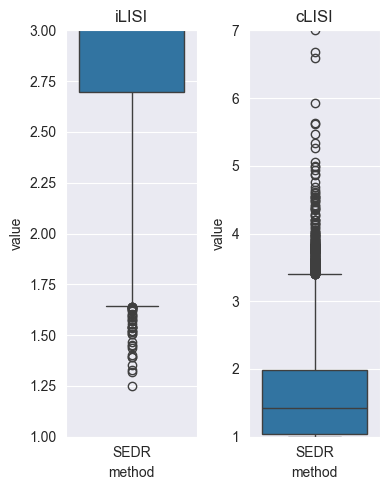

In [13]:
import harmonypy as hm

iLISI = hm.compute_lisi(adata.obsm['SEDR.Harmony'], adata.obs[['batch_name']], label_colnames=['batch_name'])[:, 0]
cLISI = hm.compute_lisi(adata.obsm['SEDR.Harmony'], adata.obs[['layer_guess']], label_colnames=['layer_guess'])[:, 0]
df_iLISI = pd.DataFrame({
    'method': 'SEDR',
    'value': iLISI,
    'type': ['ILISI'] * len(iLISI)
})

df_cLISI = pd.DataFrame({
    'method': 'SEDR',
    'value': cLISI,
    'type': ['CLISI'] * len(cLISI)
})

fig, axes = plt.subplots(1, 2, figsize=(4, 5))
sns.boxplot(data=df_iLISI, x='method', y='value', ax=axes[0])
sns.boxplot(data=df_cLISI, x='method', y='value', ax=axes[1])
axes[0].set_ylim(1, 3)
axes[1].set_ylim(1, 7)
axes[0].set_title('iLISI')
axes[1].set_title('cLISI')

plt.tight_layout()
print(np.median(iLISI))
print(np.median(cLISI))

## Visualizing

### UMAP

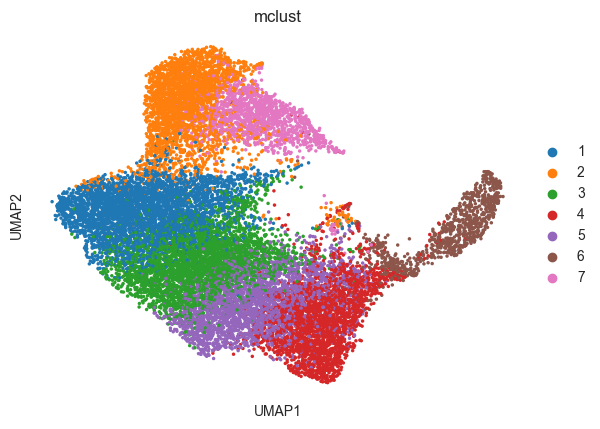

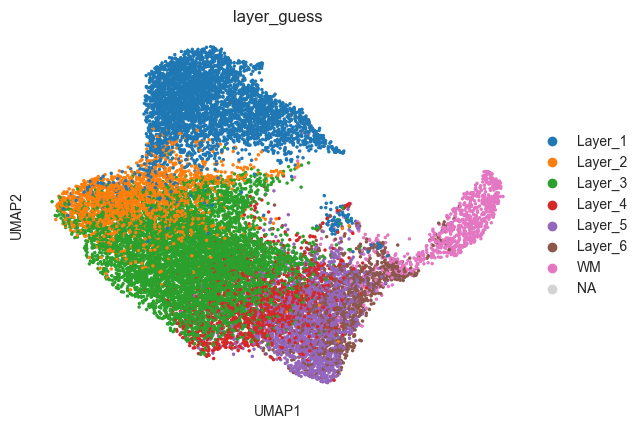

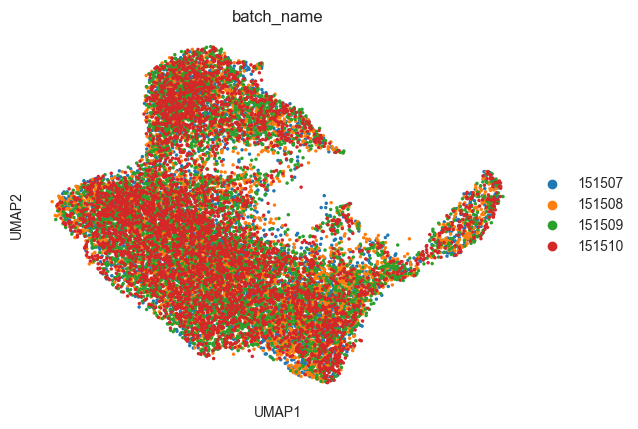

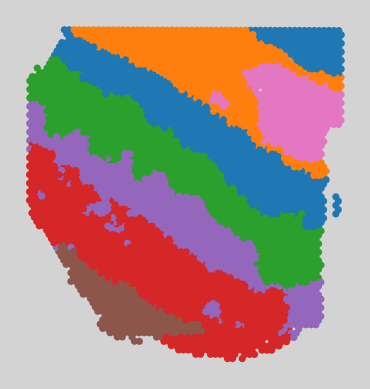

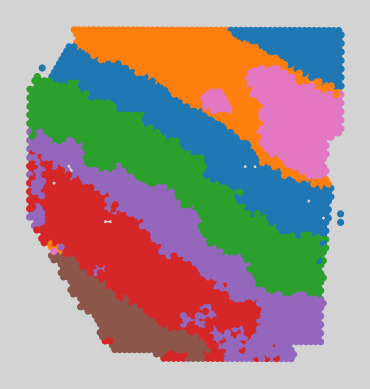

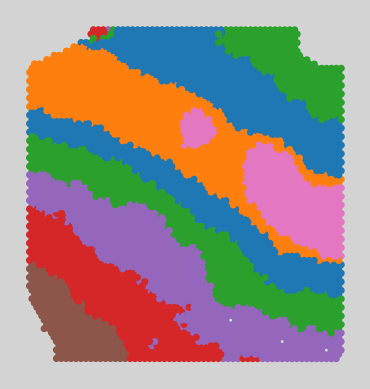

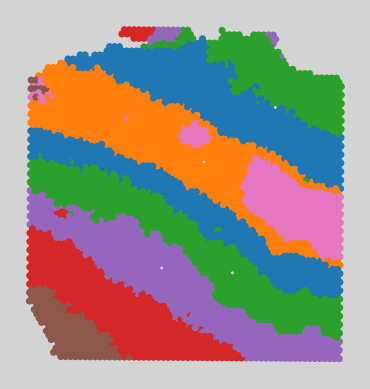

In [14]:
plt.rcParams['axes.facecolor'] = 'white'  # 设置子图的背景颜色
plt.rcParams['figure.facecolor'] = 'white'  # 设置整张图的背景颜色

sc.pp.neighbors(adata, use_rep='SEDR.Harmony', random_state=666)
sc.tl.umap(adata, random_state=666)

sc.pl.umap(adata, color=['mclust'], show=True, size=25, save='SEDR_M_Donor1.png')
sc.pl.umap(adata, color=['layer_guess'], show=True, size=25, save='SEDR_G_Donor1.png')
sc.pl.umap(adata, color=['batch_name'], show=True, size=25, save='SEDR_B_Donor1.png')

plt.rcParams['axes.facecolor'] = 'lightgray'  # 设置子图的背景颜色
plt.rcParams['figure.facecolor'] = 'lightgray'  # 设置整张图的背景颜色

for section_id in proj_list:
    adata_tmp = adata[adata.obs['batch_name'] == section_id]
    sc.pl.spatial(adata_tmp, img_key=None, color=['mclust'], title=[''],
                  legend_fontsize=12, show=False, frameon=False, legend_loc=None,
                  spot_size=200)

    plt.savefig('figures/SEDR_' + section_id + '.png', dpi=300, bbox_inches='tight')

In [12]:
sc.pp.neighbors(adata, use_rep='SEDR.Harmony', metric='cosine')
sc.tl.umap(adata)

[<Axes: title={'center': 'layer_guess'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'batch_name'}, xlabel='UMAP1', ylabel='UMAP2'>]

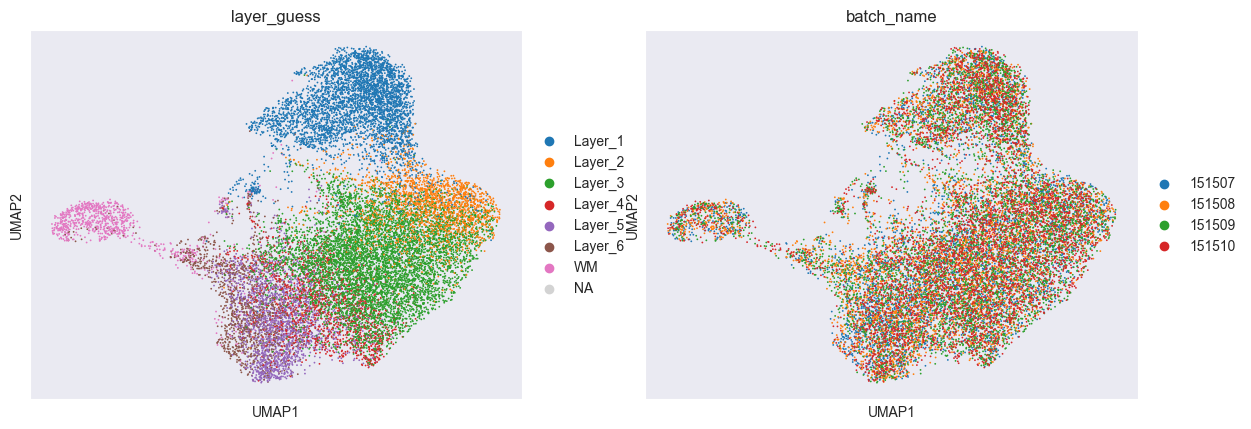

In [13]:
sc.pl.umap(adata, color=['layer_guess', 'batch_name'], show=False)

### LISI score

In [14]:
ILISI = hm.compute_lisi(adata.obsm['SEDR.Harmony'], adata.obs[['batch']], label_colnames=['batch'])[:, 0]
CLISI = hm.compute_lisi(adata.obsm['SEDR.Harmony'], adata.obs[['layer_guess']], label_colnames=['layer_guess'])[:, 0]

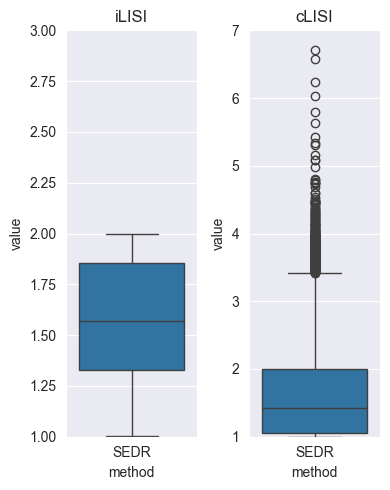

In [15]:
df_ILISI = pd.DataFrame({
    'method': 'SEDR',
    'value': ILISI,
    'type': ['ILISI']*len(ILISI)
})


df_CLISI = pd.DataFrame({
    'method': 'SEDR',
    'value': CLISI,
    'type': ['CLISI']*len(CLISI)
})

fig, axes = plt.subplots(1,2,figsize=(4, 5))
sns.boxplot(data=df_ILISI, x='method', y='value', ax=axes[0])
sns.boxplot(data=df_CLISI, x='method', y='value', ax=axes[1])
axes[0].set_ylim(1, 3)
axes[1].set_ylim(1, 7)
axes[0].set_title('iLISI')
axes[1].set_title('cLISI')

plt.tight_layout()